In [3]:
from glob import glob
import pandas as pd
import altair as alt
import numpy as np

%matplotlib inline 
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [46]:
df = pd.read_csv("../data/random_undirected_disjoint_0.001_up_0.3_down.csv", parse_dates=["datetime"])
df[df["datetime"]==pd.to_datetime("1995-03-11 00:00:00")]

,datetime,source,destination
51054,1995-03-11,15,0
51055,1995-03-11,48,39
51056,1995-03-11,53,3
51057,1995-03-11,70,20
51058,1995-03-11,73,37
...,...,...,...
51220,1995-03-11,492,383
51221,1995-03-11,493,26
51222,1995-03-11,496,167
51223,1995-03-11,497,129


0.0020011490427397517

<AxesSubplot:ylabel='Frequency'>

0.002000739199832329

<AxesSubplot:ylabel='Frequency'>

0.0020010975410972146

<AxesSubplot:ylabel='Frequency'>

0.0020011401702461308

<AxesSubplot:ylabel='Frequency'>

0.0020009187572897777

<AxesSubplot:ylabel='Frequency'>

0.0020009847874761545

<AxesSubplot:ylabel='Frequency'>

0.00200095112192023

<AxesSubplot:ylabel='Frequency'>

0.0020006289178736317

<AxesSubplot:ylabel='Frequency'>

0.0020011478170274583

<AxesSubplot:ylabel='Frequency'>

,up,down,activity,x
0,0.001,0.7,0.002,0.0007
1,0.001,0.5,0.002,0.0005
2,0.004,0.5,0.002,0.0020
3,0.001,0.3,0.002,0.0003
4,0.004,0.7,0.002,0.0028
5,0.002,0.7,0.002,0.0014
6,0.002,0.5,0.002,0.0010
7,0.002,0.3,0.002,0.0006
8,0.004,0.3,0.002,0.0012


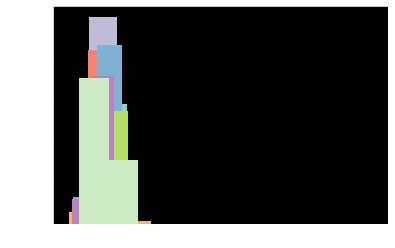

In [39]:
d = {"up": [], "down": [], "activity": []}
for path in glob("../data/random_undirected_random*.csv"):
    df = pd.read_csv(path, parse_dates=["datetime"])
    merged = pd.merge(
        df.rename(columns={"source": "id"})
        .groupby([pd.Grouper(freq="1D", key="datetime"), "id"])
        .count(),
        df.rename(columns={"destination": "id"})
        .groupby([pd.Grouper(freq="1D", key="datetime"), "id"])
        .count(),
        left_index=True,
        right_index=True,
        how="outer",
    ).fillna(0)
    merged["activity"] = merged["destination"] + merged["source"]
    merged = pd.merge(
        merged,
        merged.groupby("datetime")["activity"].sum(),
        left_on="datetime",
        right_index=True,
    )
    merged["activity"] = merged["activity_x"] / merged["activity_y"]
    display(merged.groupby("id")["activity"].mean().plot.hist())
    d["up"].append(path.split("_")[3])
    d["down"].append(path.split("_")[5])
    d["activity"].append(merged.groupby("id")["activity"].mean().mean())
# dd = pd.DataFrame(d)
# dd["x"] = dd["up"].astype(float) * dd["down"].astype(float)
dd


In [ ]:
merged.reset_index().groupby(
    [pd.Grouper(freq="1D", key="datetime"), "id"]
).mean().groupby("id").mean()[["activity"]].plot.hist(bins=100)

In [7]:
df = pd.read_csv("../data/copenhagen_agg.csv", parse_dates=["time"])
for frequency in ("1D","12H","8H"):
    dfl = (
        df.groupby([pd.Grouper(freq=frequency, key="time"), "duration"])
        .count()["source"]
        .groupby("duration")
        .mean()
    )
    # dfl = dfl / sum(dfl)
    dfl = dfl.reset_index().rename(columns={"source": "count"})
    dfl["duration"] = np.log(dfl["duration"])
    chart = (alt.Chart(dfl).mark_bar().encode(
        x=alt.X("duration:Q", bin=True, title=r"Log-Scale Duration (Binned) - $e^x$ Minutes"),
        y=alt.Y("sum(count)", title="Amount", scale=alt.Scale(domain=(0,8000))),
    ).configure_axis(
    labelFontSize=14,
    titleFontSize=20
))
    chart.save(f"{frequency}.html")

In [93]:
for i in ("2455194997769553", "3882112953242523", "5157036832648648", "6933653713418433"):
    x = pd.read_csv(f"../output/{i}_metrics.csv").groupby("metric").agg(['mean', 'count', 'std']).loc["r_0"]["value"]
    # display(x)
    print(f"{round(x['mean'], 2)} +- {1.96*x['std']/np.sqrt(x['count'])}")


0.31 +- 0.0029697481488115446
0.27 +- 0.0020371880749325538
0.31 +- 0.0008030756801917476
0.28 +- 0.0008265937996641793


In [8]:
df = pd.read_csv("../data/copenhagen_agg.csv", parse_dates=["time"])
a1 = pd.date_range(
    start=pd.to_datetime("2021-03-12"), end=pd.to_datetime("2021-04-08"), freq="1D"
)
a2 = sorted(set(df["source"].to_list()) | set(df["destination"].to_list()))
mi = pd.MultiIndex.from_product([a1, a2], names=["time", "id"])
for frequency in ("1D", "12H", "8H"):
    merged = (
        pd.merge(
            df.rename(columns={"source": "id"}).groupby(["time", "id"]).count(),
            df.rename(columns={"destination": "id"}).groupby(["time", "id"]).count(),
            left_index=True,
            right_index=True,
            how="outer",
        )
        .fillna(0)
        .reset_index()
    )
    merged["activity"] = merged["destination"] + merged["source"]
    dfl = merged.groupby([pd.Grouper(freq=frequency, key="time"), "id"])[
        "activity"
    ].sum()
    dfl = dfl / dfl.groupby(level=0).sum()
    mean = (
        pd.merge(
            pd.DataFrame([], index=mi),
            dfl,
            left_index=True,
            right_index=True,
            how="left",
        )
        .fillna(0)
        .groupby(level=1)["activity"]
        .mean()
        .reset_index()
    )
    display(
        alt.Chart(mean)
        .mark_bar(color="#92c5de")
        .encode(
            x=alt.X(
                "activity:Q", bin=alt.Bin(extent=[0, 0.01], step=0.0005), title="Average Activity Potential (Binned)"
            ),
            y=alt.Y("count(activity)", title="Nodes", scale=alt.Scale(domain=(0, 550))),
        )
        .configure_axis(labelFontSize=14, titleFontSize=20)
    )


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [20]:

for max_date in [
    pd.Timestamp("2021-04-08"),
    pd.Timestamp("2021-03-25"),
    pd.Timestamp("2021-03-19"),
]:
    df = pd.read_csv("../data/copenhagen_agg.csv", parse_dates=["time"])
    df = df[df["time"] <= max_date]
    idf = pd.Series(
        sorted(set(df["source"].to_list()) | set(df["destination"].to_list()))
    ).to_frame(name="id")
    merged = (
        pd.merge(
            df.rename(columns={"source": "id"}).groupby("id").count(),
            df.rename(columns={"destination": "id"}).groupby("id").count(),
            left_index=True,
            right_index=True,
            how="outer",
        )
        .fillna(0)
    )
    merged["activity"] = merged["destination"] + merged["source"]
    merged = merged / merged.sum()
    zeroes = pd.merge(idf, merged, left_on="id", right_index=True, how="left").fillna(0)[["activity"]]
    chart = (alt.Chart(zeroes)
        .mark_bar(color="#92c5de")
        .encode(
            x=alt.X(
                "activity:Q",
                bin=alt.Bin(extent=[0, 0.006], step=0.0005),
                title="Activity Potential (Binned)",
            ),
            y=alt.Y("count(activity)", title="Nodes", scale=alt.Scale(domain=(0, 300))),
        )
        .configure_axis(labelFontSize=14, titleFontSize=20)
    )
    display(chart)
    # chart.save(f"{str(max_date)}.html")

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [169]:
pd.Timestamp('2021-03-25')

Timestamp('2021-03-25 00:00:00')

In [170]:
pd.to_datetime("2021-04-08") - pd.to_timedelta("18D") #pd.to_datetime("2021-04-08")

Timestamp('2021-03-21 00:00:00')

,duration,time,source,destination
0,175,2021-03-12 00:00:00,249,530
1,30,2021-03-12 00:00:00,221,263
2,230,2021-03-12 00:00:00,568,599
3,45,2021-03-12 00:00:00,48,49
4,20,2021-03-12 00:00:00,170,390
...,...,...,...,...
446154,5,2021-04-08 23:55:00,138,490
446155,5,2021-04-08 23:55:00,206,560
446156,5,2021-04-08 23:55:00,71,561
446157,5,2021-04-08 23:55:00,194,371


In [128]:
{1, 2} | {2,3}

{1, 2, 3}

0.9999999999999999

In [ ]:
for path in glob("data/random_undirected_er*.csv"):
    df = pd.read_csv(path)
    df["datetime"] = pd.to_datetime("1995-03-10") + (df["datetime"] * pd.to_timedelta("5m"))
    new_path = f"random_undirected_{('disjoint' if 'disjoint' in path else 'random')}_{'_'.join(path.split('_')[7:11])}.csv"
    df.to_csv(new_path, index=False)
